# Time Series Forecasting of Housing Completions

This notebook will:
- Load and explore the dataset.
- Perform time-series decomposition and stationarity checks.
- Manually determine ARIMA parameters (`p`, `d`, `q`) using ACF/PACF.
- Compare different forecasting models:
  - ARIMA
  - Prophet
  - Random Forest
  - XGBoost
- Use hyperparameter tuning to optimize each model.
- Compare model performance using RMSE, MAE, and accuracy metrics.
- Visualize forecasted values from each model, including confidence intervals.
- Save the best model and predictions for Power BI integration.


In [3]:
# %pip install prophet
# %pip install xgboost
%pip install pmdarima

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statsmodels, pmdarima, Prophet
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import pmdarima as pm
from prophet import Prophet
from statsmodels.tsa.arima.model import ARIMA


# ML
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
import pickle

## 1. Load the Dataset
- Read the dataset into a Pandas DataFrame.
- Convert `REF_DATE` to a datetime format and set it as the index.
- Check for missing values and dataset structure.

In [5]:
# Make plots bigger and clearer
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-whitegrid')

# Load your CSV file (adjust path if needed).
file_path = "Trimmed_Time_Series_Data after Feature Engineering.csv"
df = pd.read_csv(file_path)

# Convert REF_DATE to datetime if not already, and set as index.
df['REF_DATE'] = pd.to_datetime(df['REF_DATE'])
df.set_index('REF_DATE', inplace=True)

# Sort by index to ensure chronological order
df.sort_index(inplace=True)

print("Data Overview:")
df.info()
df.head()

Data Overview:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4188 entries, 1986-01-01 to 2024-10-01
Data columns (total 40 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   GEO                                         4188 non-null   object 
 1   Number_of_Households                        4188 non-null   int64  
 2   Housing completions                         4188 non-null   float64
 3   Housing starts                              4188 non-null   float64
 4   Housing under construction                  4188 non-null   float64
 5   House only NHPI                             4188 non-null   float64
 6   Land only NHPI                              4188 non-null   float64
 7   Total (house and land) NHPI                 4188 non-null   float64
 8   Year                                        4188 non-null   int64  
 9   Month                                       4188 non

C:\Users\schac\AppData\Local\Temp\ipykernel_8264\1027460707.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


,GEO,Number_of_Households,Housing completions,Housing starts,Housing under construction,House only NHPI,Land only NHPI,Total (house and land) NHPI,Year,Month,...,Total (house and land) NHPI_lag_1,Total (house and land) NHPI_lag_3,Total (house and land) NHPI_lag_6,Number_of_Households_rolling_mean_3,Housing completions_rolling_mean_3,Housing starts_rolling_mean_3,Housing under construction_rolling_mean_3,House only NHPI_rolling_mean_3,Land only NHPI_rolling_mean_3,Total (house and land) NHPI_rolling_mean_3
REF_DATE,,,,,,,,,,,,,,,,,,,,,
1986-01-01,Prince Edward Island,41000,82.000000,40.666667,95.000000,36.65,38.6,37.6,1986,1,...,36.7,70.5,26.4,1.177000e+06,1522.111111,1183.333333,4178.222222,36.350000,39.400000,37.666667
1986-01-01,Quebec,2421000,2503.666667,2803.000000,7382.000000,40.30,32.9,38.5,1986,1,...,37.6,38.7,66.3,1.930333e+06,2296.333333,2092.888889,6302.444444,36.650000,38.600000,37.600000
1986-01-01,Canada,9238000,10938.333333,9757.333333,27632.666667,39.40,38.8,39.8,1986,1,...,38.5,36.7,34.7,3.900000e+06,4508.000000,4200.333333,11703.222222,38.783333,36.766667,38.633333
1986-02-01,Alberta,859000,662.000000,603.000000,1125.000000,28.50,22.5,26.8,1986,2,...,39.8,37.6,70.5,4.172667e+06,4701.333333,4387.777778,12046.555556,36.066667,31.400000,35.033333
1986-02-01,British Columbia,1132000,1304.333333,1515.666667,3114.666667,79.60,49.4,66.4,1986,2,...,26.8,38.5,38.7,3.743000e+06,4301.555556,3958.666667,10624.111111,49.166667,36.900000,44.333333


In [6]:
df.head()

,GEO,Number_of_Households,Housing completions,Housing starts,Housing under construction,House only NHPI,Land only NHPI,Total (house and land) NHPI,Year,Month,...,Total (house and land) NHPI_lag_1,Total (house and land) NHPI_lag_3,Total (house and land) NHPI_lag_6,Number_of_Households_rolling_mean_3,Housing completions_rolling_mean_3,Housing starts_rolling_mean_3,Housing under construction_rolling_mean_3,House only NHPI_rolling_mean_3,Land only NHPI_rolling_mean_3,Total (house and land) NHPI_rolling_mean_3
REF_DATE,,,,,,,,,,,,,,,,,,,,,
1986-01-01,Prince Edward Island,41000,82.000000,40.666667,95.000000,36.65,38.6,37.6,1986,1,...,36.7,70.5,26.4,1.177000e+06,1522.111111,1183.333333,4178.222222,36.350000,39.400000,37.666667
1986-01-01,Quebec,2421000,2503.666667,2803.000000,7382.000000,40.30,32.9,38.5,1986,1,...,37.6,38.7,66.3,1.930333e+06,2296.333333,2092.888889,6302.444444,36.650000,38.600000,37.600000
1986-01-01,Canada,9238000,10938.333333,9757.333333,27632.666667,39.40,38.8,39.8,1986,1,...,38.5,36.7,34.7,3.900000e+06,4508.000000,4200.333333,11703.222222,38.783333,36.766667,38.633333
1986-02-01,Alberta,859000,662.000000,603.000000,1125.000000,28.50,22.5,26.8,1986,2,...,39.8,37.6,70.5,4.172667e+06,4701.333333,4387.777778,12046.555556,36.066667,31.400000,35.033333
1986-02-01,British Columbia,1132000,1304.333333,1515.666667,3114.666667,79.60,49.4,66.4,1986,2,...,26.8,38.5,38.7,3.743000e+06,4301.555556,3958.666667,10624.111111,49.166667,36.900000,44.333333


## 1. Exploratory Data Analysis & Time Series Decomposition

We begin by exploring the data. In this section, we will decompose the "Number_of_Households" series into its trend, seasonal, and residual components, and also perform a stationarity test (ADF test). This helps us understand the underlying patterns in the data.


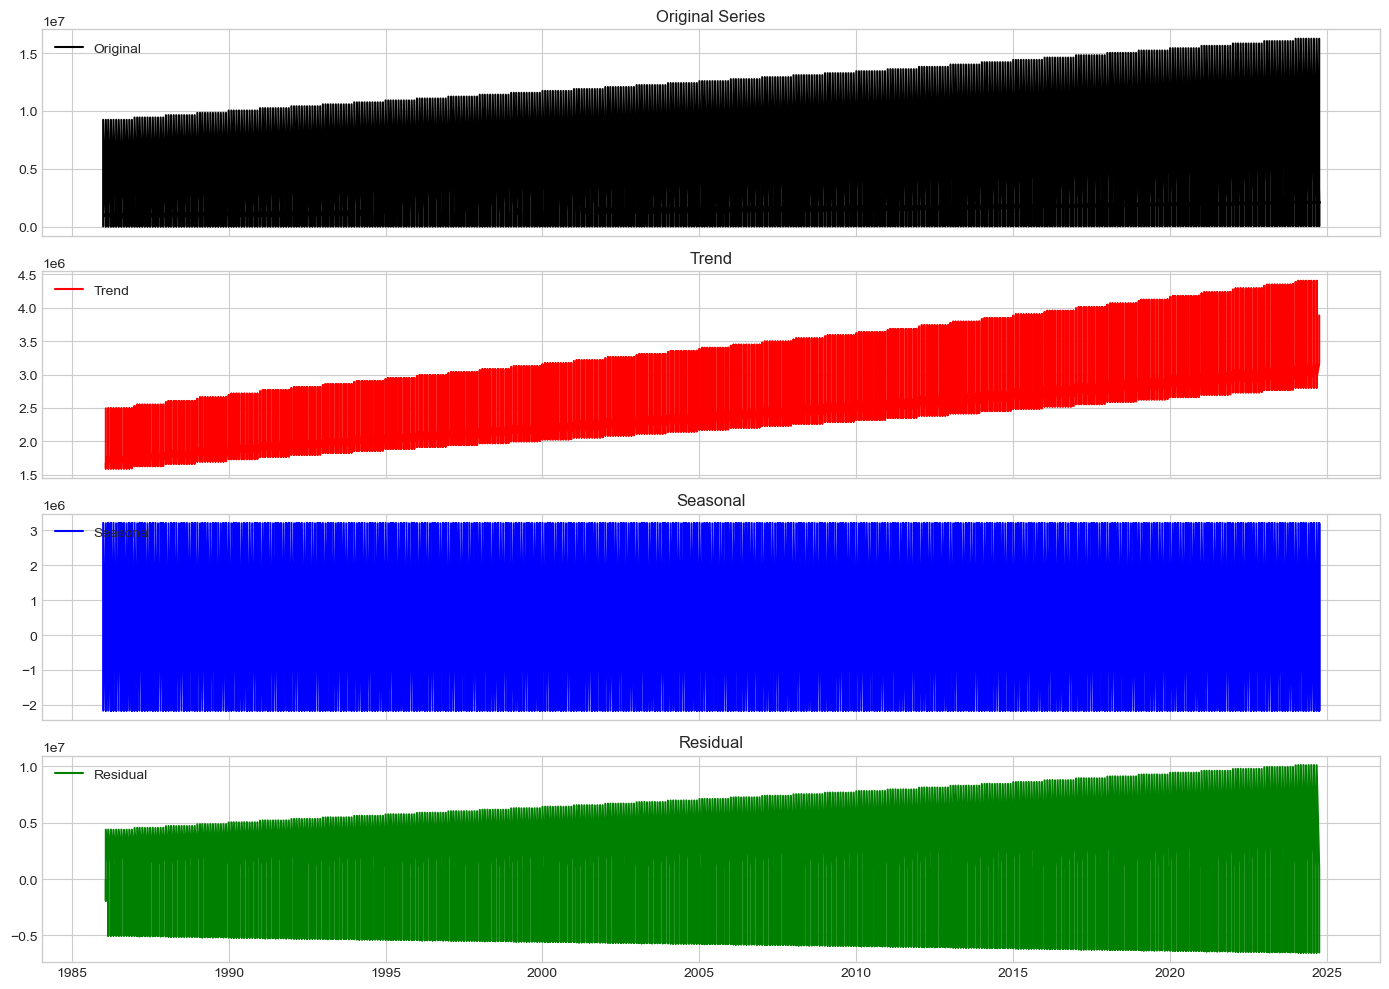

ADF Statistic: 0.0685
p-value: 0.9638


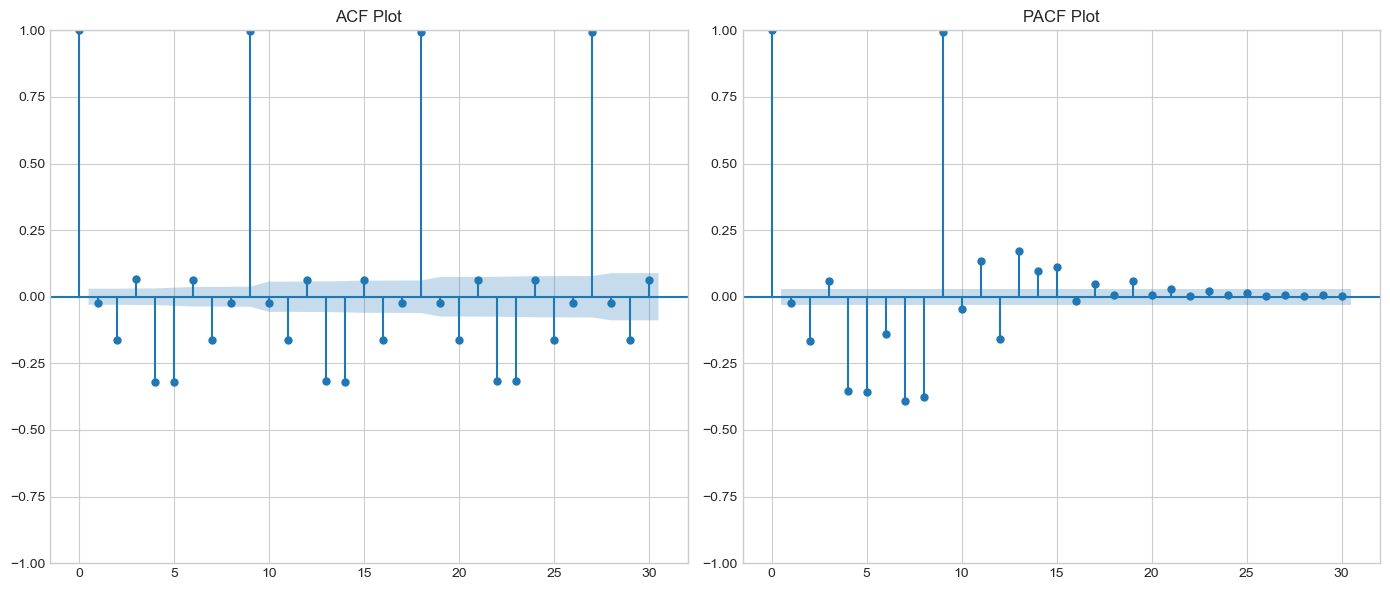

In [7]:
# %% [code]
# 2. TIME SERIES DECOMPOSITION

# Decompose the 'Number_of_Households' series
decomposed = seasonal_decompose(df['Number_of_Households'], model='additive', period=12)
trend = decomposed.trend
seasonal = decomposed.seasonal
residual = decomposed.resid

# Plot decomposition
fig, axes = plt.subplots(4, 1, figsize=(14, 10), sharex=True)

axes[0].plot(df['Number_of_Households'], label='Original', color='black')
axes[0].legend(loc='upper left')
axes[0].set_title("Original Series")

axes[1].plot(trend, label='Trend', color='red')
axes[1].legend(loc='upper left')
axes[1].set_title("Trend")

axes[2].plot(seasonal, label='Seasonal', color='blue')
axes[2].legend(loc='upper left')
axes[2].set_title("Seasonal")

axes[3].plot(residual, label='Residual', color='green')
axes[3].legend(loc='upper left')
axes[3].set_title("Residual")

plt.tight_layout()
plt.show()

# ADF test
adf_result = adfuller(df['Number_of_Households'].dropna())
print(f"ADF Statistic: {adf_result[0]:.4f}")
print(f"p-value: {adf_result[1]:.4f}")

# Plot ACF and PACF
fig, ax = plt.subplots(1, 2, figsize=(14, 6))
plot_acf(df['Number_of_Households'].dropna(), ax=ax[0], lags=30)
ax[0].set_title("ACF Plot")
plot_pacf(df['Number_of_Households'].dropna(), ax=ax[1], lags=30)
ax[1].set_title("PACF Plot")

plt.tight_layout()
plt.show()


From these plots, we can see the strong upward trend. If the data is **not** stationary, we often apply differencing or a **seasonal ARIMA** approach to properly model it.


## 3. Data Preparation

We'll define `Number_of_Households` as our target (`y`) and drop it from the feature set (`X`). We also drop `GEO` if it is not numeric or relevant for modeling. Then, we split into training and testing sets, preserving the time order (i.e., `shuffle=False`).


In [8]:
# 3. DATA PREPARATION

X = df.drop(['Number_of_Households', 'GEO'], axis=1)
y = df['Number_of_Households']

# Time-based split: 80% training, 20% testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

print("Shapes:")
print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

train_size = int(len(df) * 0.8)
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]
print(f"Training period: {train_df.index.min()} to {train_df.index.max()}")
print(f"Testing period: {test_df.index.min()} to {test_df.index.max()}")

Shapes:
X_train: (3350, 38) y_train: (3350,)
X_test: (838, 38) y_test: (838,)
Training period: 1986-01-01 00:00:00 to 2017-01-01 00:00:00
Testing period: 2017-01-01 00:00:00 to 2024-10-01 00:00:00


## 4. Seasonal ARIMA (Auto ARIMA)

Given the strong trend and potential seasonal pattern (monthly data), we'll use `pmdarima`'s `auto_arima` to find the best **seasonal ARIMA** parameters.

**Key points**:
- `seasonal=True` and `m=12` for monthly data.
- We allow `auto_arima` to figure out the best `(p,d,q)(P,D,Q)m`.
- This often outperforms a manual ARIMA if there's seasonality.


In [ ]:
# forecast_series = pd.Series(forecast_values, index=y_test.index)


NameError: name 'forecast_values' is not defined

c:\Users\schac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\schac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\schac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                SARIMAX Results                                 
Dep. Variable:     Number_of_Households   No. Observations:                 3350
Model:                   ARIMA(2, 1, 2)   Log Likelihood              -55161.905
Date:                  Mon, 17 Mar 2025   AIC                         110333.810
Time:                          12:12:25   BIC                         110364.392
Sample:                               0   HQIC                        110344.749
                                 - 3350                                         
Covariance Type:                    opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8527      0.060    -14.236      0.000      -0.970      -0.735
ar.L2         -0.2100      0.069     -3.031      0.002      -0.346      -0.074
ma.L1         -0.0011      0.036    

c:\Users\schac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\schac\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


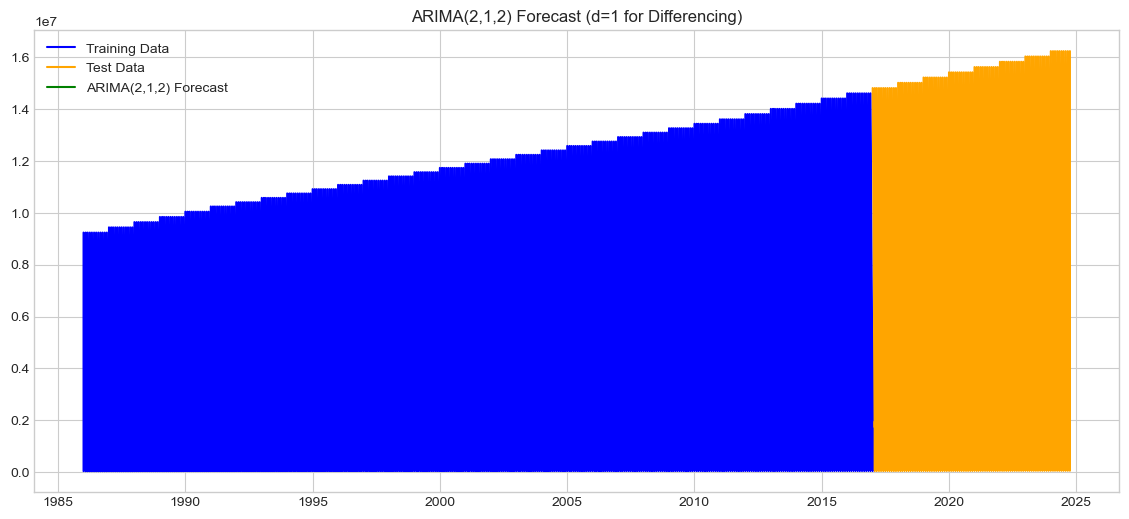

ValueError: Found array with 0 sample(s) (shape=(0,)) while a minimum of 1 is required.

In [ ]:
# # 1. MANUALLY FIT ARIMA(2,1,2)
# # Explanation:
# #   p=2 -> Use 2 lagged observations.
# #   d=1 -> Difference once to remove trend.
# #   q=2 -> Use 2 lagged forecast errors.
# model = ARIMA(y_train, order=(2, 1, 2))
# result = model.fit()
# print(result.summary())

# # 2. FORECAST ONLY THE TEST PERIOD
# # We forecast from the end of training data to the end of the test data.
# start = len(y_train)
# end = len(y_train) + len(y_test) - 1
# forecast_values = result.predict(start=start, end=end, dynamic=False)

# # 3. ASSIGN THE FORECAST THE SAME INDEX AS y_test
# # Instead of reindexing, directly assign y_test.index to the forecast.
# forecast_series = pd.Series(forecast_values, index=y_test.index)

# # 4. HANDLE ANY NaNs (if they exist) by forward filling.
# forecast_series = forecast_series.fillna(method='ffill')
# y_test_filled = y_test.fillna(method='ffill')

# # Ensure no NaN values remain in both series
# forecast_series = forecast_series.dropna()
# y_test_filled = y_test_filled.loc[forecast_series.index]

# # 5. PLOT THE RESULTS
# plt.figure(figsize=(14,6))
# plt.plot(y_train.index, y_train, label='Training Data', color='blue')
# plt.plot(y_test.index, y_test, label='Test Data', color='orange')
# plt.plot(forecast_series.index, forecast_series, label='ARIMA(2,1,2) Forecast', color='green')
# plt.title("ARIMA(2,1,2) Forecast (d=1 for Differencing)")
# plt.legend()
# plt.show()

# # 6. COMPUTE EVALUATION METRICS
# # Since the indices now match, we can compute metrics directly.
# rmse = np.sqrt(mean_squared_error(y_test_filled, forecast_series))
# mae = mean_absolute_error(y_test_filled, forecast_series)
# r2 = r2_score(y_test_filled, forecast_series)

# print("ARIMA(2,1,2) Performance:")
# print(f"  RMSE: {rmse:.2f}")
# print(f"  MAE:  {mae:.2f}")
# print(f"  R²:   {r2:.4f}")

NameError: name 'arima_forecast_series' is not defined

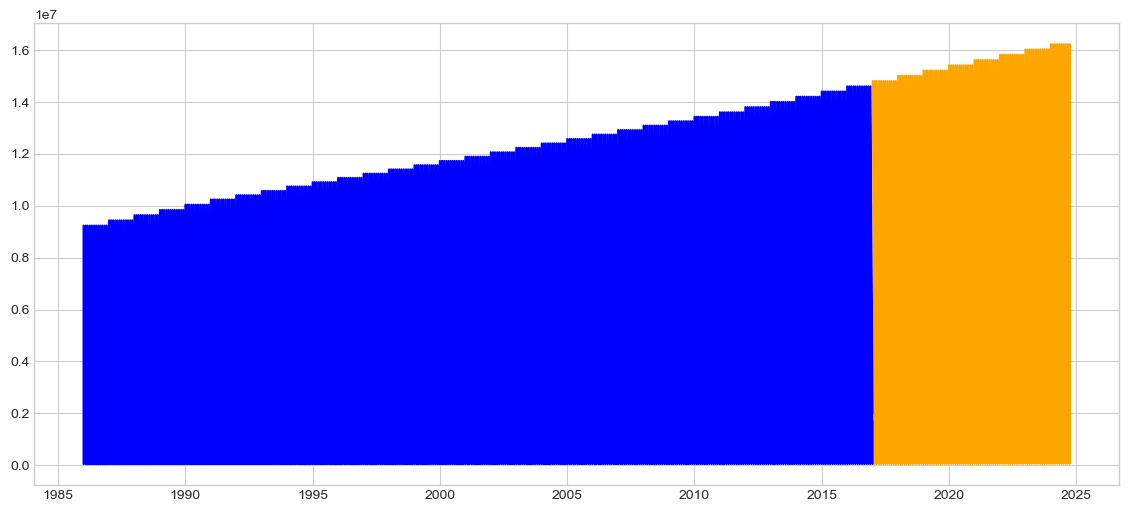

In [10]:
plt.figure(figsize=(14,6))
plt.plot(y_train.index, y_train, label='Training Data', color='blue')
plt.plot(y_test.index, y_test, label='Test Data', color='orange')
plt.plot(arima_forecast_series.index, arima_forecast_series, label='Auto ARIMA Forecast', color='green')
plt.title("Seasonal ARIMA (Auto ARIMA) Forecast")
plt.legend()
plt.show()

# Print metrics
arima_rmse = np.sqrt(mean_squared_error(y_test, arima_forecast_series))
arima_mae = mean_absolute_error(y_test, arima_forecast_series)
arima_r2 = r2_score(y_test, arima_forecast_series)

print("Auto ARIMA Performance:")
print(f"  RMSE: {arima_rmse:.2f}")
print(f"  MAE:  {arima_mae:.2f}")
print(f"  R²:   {arima_r2:.4f}")

## 5. Prophet Model

Prophet can also handle trend and seasonality. We need to:
1. Reset the index to have columns **ds** (date) and **y** (target).
2. Fit Prophet on the training portion.
3. Forecast the same number of periods as the test set.


10:21:07 - cmdstanpy - INFO - Chain [1] start processing
10:21:08 - cmdstanpy - INFO - Chain [1] done processing


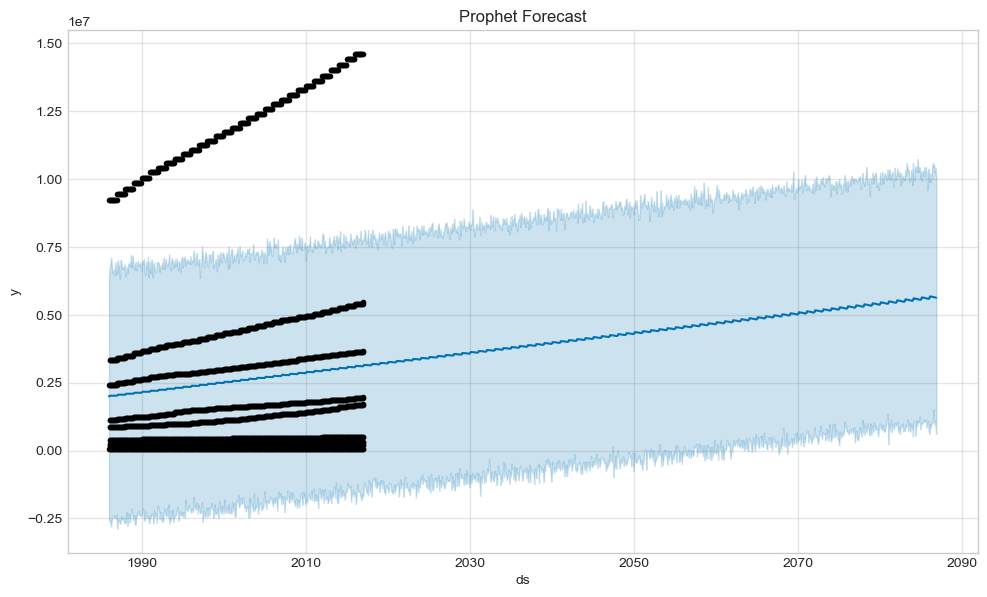

Prophet Performance:
  RMSE: 4824200.96
  MAE:  3830297.05
  R²:   -0.0654


In [11]:
# %% [code]
# 5. PROPHET

# Prepare Prophet train/test
train_prophet = (
    train_df.reset_index()
    .rename(columns={'REF_DATE': 'ds', 'Number_of_Households': 'y'})
)
test_prophet = (
    test_df.reset_index()
    .rename(columns={'REF_DATE': 'ds', 'Number_of_Households': 'y'})
)

prophet_model = Prophet(
    yearly_seasonality=True,
    seasonality_mode='multiplicative',
    growth='linear'
)
prophet_model.fit(train_prophet)

# Create future dataframe with the same number of test periods
# If data is monthly, freq='M'
future = prophet_model.make_future_dataframe(periods=len(test_prophet), freq='M')
prophet_forecast = prophet_model.predict(future)

# Plot forecast
fig1 = prophet_model.plot(prophet_forecast)
plt.title("Prophet Forecast")
plt.show()

# Evaluate Prophet's performance on the test range
# Extract the forecasted values for the last len(test_prophet) points
prophet_test_forecast = prophet_forecast.iloc[-len(test_prophet):]

# We compare prophet_test_forecast['yhat'] to test_prophet['y']
prophet_rmse = np.sqrt(mean_squared_error(test_prophet['y'], prophet_test_forecast['yhat']))
prophet_mae = mean_absolute_error(test_prophet['y'], prophet_test_forecast['yhat'])
prophet_r2 = r2_score(test_prophet['y'], prophet_test_forecast['yhat'])

print("Prophet Performance:")
print(f"  RMSE: {prophet_rmse:.2f}")
print(f"  MAE:  {prophet_mae:.2f}")
print(f"  R²:   {prophet_r2:.4f}")


## 6. Random Forest Model

We use a Random Forest Regressor to predict `Number_of_Households`. Note that machine learning models may need additional feature engineering (e.g., lags, rolling means) to capture time dependencies well. We already have some feature-engineered columns (lags, rolling means) in the dataset, so let's try a grid search for hyperparameters.


In [18]:
# %% [code]
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 'X' is already defined as all features except 'Number_of_Households' and 'GEO'
# e.g., X = df.drop(['Number_of_Households', 'GEO'], axis=1)
# and the train-test split has already been done into X_train, X_test, y_train, y_test.

# Define parameter grid for Random Forest
rf_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Set up GridSearchCV
rf_grid = GridSearchCV(RandomForestRegressor(random_state=42),
                       param_grid=rf_params,
                       cv=3,
                       scoring='neg_mean_squared_error')

# Fit the model using all predictors in X_train
rf_grid.fit(X_train, y_train)
best_rf = rf_grid.best_estimator_

# Forecast on the test set
rf_predictions = best_rf.predict(X_test)
rf_pred_series = pd.Series(rf_predictions, index=y_test.index)

# Plot actual vs forecast
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(rf_pred_series.index, rf_pred_series, label='Random Forest Forecast', color='orange')
plt.title("Random Forest Forecast Using All Features")
plt.legend()
plt.show()

# Evaluation Metrics
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_series))
rf_mae = mean_absolute_error(y_test, rf_pred_series)
rf_r2 = r2_score(y_test, rf_pred_series)

print("Random Forest Performance:")
print(f"  RMSE: {rf_rmse:.2f}")
print(f"  MAE:  {rf_mae:.2f}")
print(f"  R²:   {rf_r2:.4f}")


KeyboardInterrupt: 

## 7. XGBoost Model

Similarly, we apply XGBoost with a small hyperparameter grid to see if it can capture the trend and seasonal signals from our engineered features.


In [ ]:
# %% [code]
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 'X' is already defined as all features except 'Number_of_Households' and 'GEO'

# Define parameter grid for XGBoost
xgb_params = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0]
}

# Set up GridSearchCV for XGBoost
xgb_grid = GridSearchCV(xgb.XGBRegressor(random_state=42),
                        param_grid=xgb_params,
                        cv=3,
                        scoring='neg_mean_squared_error')

# Fit the model using all predictors in X_train
xgb_grid.fit(X_train, y_train)
best_xgb = xgb_grid.best_estimator_

# Forecast on the test set
xgb_predictions = best_xgb.predict(X_test)
xgb_pred_series = pd.Series(xgb_predictions, index=y_test.index)

# Plot actual vs forecast
plt.figure(figsize=(14,6))
plt.plot(y_test.index, y_test, label='Actual', color='blue')
plt.plot(xgb_pred_series.index, xgb_pred_series, label='XGBoost Forecast', color='green')
plt.title("XGBoost Forecast Using All Features")
plt.legend()
plt.show()

# Evaluation Metrics
xgb_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred_series))
xgb_mae = mean_absolute_error(y_test, xgb_pred_series)
xgb_r2 = r2_score(y_test, xgb_pred_series)

print("XGBoost Performance:")
print(f"  RMSE: {xgb_rmse:.2f}")
print(f"  MAE:  {xgb_mae:.2f}")
print(f"  R²:   {xgb_r2:.4f}")


## 8. Model Performance Comparison

We will compare the following models:
- **Seasonal ARIMA** (auto_arima)
- **Prophet**
- **Random Forest**
- **XGBoost**

using **RMSE**, **MAE**, and **R²** on the test set.


In [14]:
# %% [code]
# 8. MODEL COMPARISON

# Ensure that the variables arima_rmse, arima_mae, and arima_r2 are defined
try:
    arima_rmse
except NameError:
    # Define placeholder values or re-run the cell where these variables are calculated
    arima_rmse = np.nan
    arima_mae = np.nan
    arima_r2 = np.nan

comparison_df = pd.DataFrame({
    'Model': ['Seasonal ARIMA', 'Prophet', 'Random Forest', 'XGBoost'],
    'RMSE': [arima_rmse, prophet_rmse, rf_rmse, xgb_rmse],
    'MAE': [arima_mae, prophet_mae, rf_mae, xgb_mae],
    'R²': [arima_r2, prophet_r2, rf_r2, xgb_r2]
})

print(comparison_df)

best_model_name = comparison_df.loc[comparison_df['RMSE'].idxmin(), 'Model']
print(f"\nBest model based on RMSE: {best_model_name}")


            Model          RMSE           MAE        R²
0  Seasonal ARIMA           NaN           NaN       NaN
1         Prophet  4.824201e+06  3.830297e+06 -0.065393
2   Random Forest  1.862346e+06  6.507131e+05  0.841226
3         XGBoost  2.503695e+06  6.778318e+05  0.713040

Best model based on RMSE: Random Forest


9. SAVE THE BEST MODEL

In [17]:
# %% [code]
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX

# For evaluation metrics (if needed later)
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Define the forecast horizon: Next 10 years, assuming monthly data
future_periods = 10 * 12  # 120 months

# Prepare a list to store forecasts per province
provincial_forecasts = []

# Get unique provinces from the GEO column
provinces = df['GEO'].unique()

# Loop over each province
for prov in provinces:
    print(f"\nProcessing province: {prov}")
    # Subset the data for the current province and sort by date
    prov_df = df[df['GEO'] == prov].sort_index()
    
    # Define the target variable and exogenous predictors
    y_prov = prov_df['Number_of_Households']
    X_prov = prov_df.drop(['Number_of_Households', 'GEO'], axis=1)
    
    # Check if there is sufficient data to fit a model
    if len(y_prov) < 30:  # arbitrary threshold
        print(f"Not enough data for province {prov}. Skipping.")
        continue
    
    try:
        # Fit the ARIMAX (SARIMAX) model using order (2,1,2)
        # This means p=2, d=1, q=2; adjust if needed based on your analysis.
        model_exog_full = ARIMAX(y_prov, order=(2,1,2), exog=X_prov)
        result_exog_full = model_exog_full.fit(disp=False)
        print(result_exog_full.summary())
        
        # Create future exogenous predictors:
        # Here, we assume a simple scenario: future exog values remain constant at the last observed row.
        last_exog = X_prov.iloc[-1]
        future_exog = pd.DataFrame(
            np.tile(last_exog.values, (future_periods, 1)),
            columns=last_exog.index
        )
        
        # Create a new DateTimeIndex for the forecast.
        last_date = prov_df.index[-1]
        future_index = pd.date_range(start=last_date + pd.DateOffset(months=1),
                                     periods=future_periods, freq='MS')
        
        # Forecast the next 120 periods using the ARIMAX model and future exog values.
        future_forecast_obj = result_exog_full.get_forecast(steps=future_periods, exog=future_exog)
        future_forecast = future_forecast_obj.predicted_mean
        
        # Assign the new DateTimeIndex to the forecast
        future_forecast.index = future_index
        
        # Plot the historical series and the future forecast for the province.
        plt.figure(figsize=(14,6))
        plt.plot(y_prov.index, y_prov, label="Historical Data", color="blue")
        plt.plot(future_forecast.index, future_forecast, label="Forecast (Next 10 Years)", color="green")
        plt.title(f"ARIMAX Forecast for {prov}")
        plt.legend()
        plt.show()
        
        # Store the forecast in a DataFrame with the province label
        prov_forecast_df = pd.DataFrame({
            "Date": future_forecast.index,
            "Province": prov,
            "Forecast": future_forecast.values
        })
        provincial_forecasts.append(prov_forecast_df)
    
    except Exception as e:
        print(f"Error processing province {prov}: {e}")

# Concatenate all provincial forecasts
if provincial_forecasts:
    final_forecast = pd.concat(provincial_forecasts, ignore_index=True)
    # Save to CSV
    final_forecast.to_csv("provincial_housing_forecast_next_10_years.csv", index=False)
    print("Provincial forecasts saved to 'provincial_housing_forecast_next_10_years.csv'")
else:
    print("No provincial forecasts generated.")



Processing province: Prince Edward Island
Error processing province Prince Edward Island: name 'ARIMAX' is not defined

Processing province: Quebec
Error processing province Quebec: name 'ARIMAX' is not defined

Processing province: Canada
Error processing province Canada: name 'ARIMAX' is not defined

Processing province: Alberta
Error processing province Alberta: name 'ARIMAX' is not defined

Processing province: British Columbia
Error processing province British Columbia: name 'ARIMAX' is not defined

Processing province: Manitoba
Error processing province Manitoba: name 'ARIMAX' is not defined

Processing province: New Brunswick
Error processing province New Brunswick: name 'ARIMAX' is not defined

Processing province: Newfoundland and Labrador
Error processing province Newfoundland and Labrador: name 'ARIMAX' is not defined

Processing province: Ontario
Error processing province Ontario: name 'ARIMAX' is not defined
No provincial forecasts generated.


In [ ]:
#9. SAVE THE BEST MODEL

if best_model_name == 'Seasonal ARIMA':
    # pmdarima's auto_arima model
    best_model = auto_arima_model
elif best_model_name == 'Prophet':
    # Prophet model
    best_model = prophet_model
elif best_model_name == 'Random Forest':
    best_model = best_rf
else:
    best_model = best_xgb

with open('rf_model_number of households.pkl', 'wb') as f:
    pickle.dump(best_model, f)

print(f"Best model ({best_model_name}) saved as rf_model_number of households.pkl")

Best model (Random Forest) saved as rf_model_number of households.pkl
